In [1]:
from __future__ import print_function, division, absolute_import
# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# set_session(tf.Session(config=config))
# from clr_callback import CyclicLR
# import dill
from BalancedDannAudioDataGenerator import BalancedAudioDataGenerator, AudioDataGenerator
import os,time
from scipy.io import loadmat
import numpy as np
np.random.seed(1)
import math
import pandas as pd
import tables,h5py
from datetime import datetime
import argparse
from keras.utils import plot_model
# from Heartnet import heartnet,getAttentionModel
from collections import Counter
# from torchviz import make_dot
def to_numpy(x):
    return x.cpu().detach().numpy()
def plotf(x):
    plt.plot(to_numpy(x))

Using TensorFlow backend.
/home/mhealthra2/anaconda3/envs/torch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mhealthra2/anaconda3/envs/torch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mhealthra2/anaconda3/envs/torch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mheal

In [2]:
# from utils import log_macc, results_log
from dataLoader import reshape_folds
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import matplotlib.pyplot as plt
# import seaborn as sns
# import Evaluator
import dataLoader
# from custom_layers import Attention
from sklearn.model_selection import train_test_split

In [3]:
class wow():
    def __init__(self):
        self.dann = True
        self.self = False
        self.reduce = None
        self.shuffle = 1
        self.mfcc = False
args = wow()

In [4]:
test_domains = 'a'
train_domains = 'bcdef'
source_domain = train_domains
target_domain = test_domains

test_split = 0
fold_dir = '../data/all_folds_wav_name/'

if(args.self):
    print("Self training activated")
    x_train, y_train, y_domain, train_parts, x_val, y_val, val_domain, val_parts,val_wav_files = dataLoader.getData(fold_dir,'',test_domains,0.9,shuffle=args.shuffle)
    print(x_train.shape, x_val.shape)
else:
    x_train, y_train, y_domain, train_parts,x_val, y_val, val_domain, val_parts, val_wav_files = dataLoader.getData(fold_dir,train_domains,test_domains,test_split,shuffle = args.shuffle)

if(args.reduce):
    print("Reduction ", args.reduce)
    x_train,_,y_train,_,y_domain,_ = train_test_split(x_train.transpose(),y_train,y_domain,stratify=y_train,test_size = args.reduce)
    x_train = x_train.transpose()

    #x_val,_,y_val,_,val_domain,_ = train_test_split(x_val.transpose(),y_val,val_domain,stratify=y_val,test_size = args.reduce)
    #x_val = x_val.transpose()

val_files = val_domain
#Create meta labels and domain labels

if(test_split>0):
    source_domain = "".join(set(source_domain).union(set(target_domain)))
    #domains = domains + test_domains

if(args.self):
    print("self training")
    source_domain = test_domains

domains = set(source_domain + target_domain)
#num_class_domain = len(set(train_domains + test_domains))
num_class_domain = len(domains)
num_class = 2

domainClass_source = [(cls,dfc) for cls in range(2) for dfc in source_domain]
domainClass_target = [(cls,dfc) for cls in range(2) for dfc in target_domain]

Train normal -  60862 - 6466  Abnormal
                90  -  9 %
Test normal -  4303 - 9864  Abnormal
               30  -  69 %


In [5]:
meta_labels_source = [domainClass_source.index((cl,df)) for (cl,df) in zip(y_train,y_domain)]
meta_labels_target = None
if(args.dann):
    meta_labels_target = [domainClass_target.index((cl,df)) for (cl,df) in zip((y_val),(val_domain))]
    

domains = "".join(set(source_domain).union(set(target_domain)))

y_domain_source = np.array([list(domains).index(lab) for lab in y_domain])

y_domain_target = np.array([list(domains).index(lab) for lab in val_domain])

################### Reshaping ############

if(args.mfcc):
    [], [y_train,y_domain,y_val] = reshape_folds([],[y_train,y_domain_source,y_val])
else:
    [x_train,x_val], [y_train,y_domain,y_val] = reshape_folds([x_train,x_val],[y_train,y_domain_source,y_val])
y_train = to_categorical(y_train, num_classes=num_class)

print("Y domain ", Counter([x[0] for x in y_domain]))
print("Val domain ", Counter(val_domain))
print("Source Meta labels ", Counter(meta_labels_source))
print("Target Meta labels ", Counter(meta_labels_target))
y_domain_source = to_categorical(y_domain_source,num_classes=num_class_domain)

y_val = to_categorical(y_val, num_classes=num_class)
y_domain_target = to_categorical(y_domain_target,num_classes=num_class_domain)


val_domain = y_domain_target
print("Train files ", y_train.shape, "  Domain ", y_domain.shape)
print("Test files ", y_val.shape, "  Domain ", val_domain.shape)

### Batch Size limmiter 
batch_size = 1000
if(batch_size > max(y_train.shape)):
    print("Batch size if given greater than train files size. limiting batch size")
    batch_size = max(y_train.shape)

reshaped x  (67328, 2500, 1)
reshaped x  (14167, 2500, 1)
reshaped Y  (67328, 1)
reshaped Y  (67328, 1)
reshaped Y  (14167, 1)
Y domain  Counter({2: 57642, 3: 4119, 4: 2985, 1: 1781, 0: 801})
Val domain  Counter({'a': 14167})
Source Meta labels  Counter({3: 54790, 4: 3012, 8: 2852, 0: 2396, 6: 1425, 9: 1107, 5: 589, 7: 493, 1: 356, 2: 308})
Target Meta labels  Counter({1: 9864, 0: 4303})
Train files  (67328, 2)   Domain  (67328, 1)
Test files  (14167, 2)   Domain  (14167, 6)


In [6]:
######## change 2500 axis for pytorch 
x_train = x_train.transpose((0,2,1))
x_val = x_val.transpose((0,2,1))

y_train = np.argmax(y_train,1)
y_val = np.argmax(y_val,1)
y_domain_target = np.argmax(y_domain_target,1)
y_domain_source = np.argmax(y_domain_source,1)

In [7]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape, y_domain_source.shape,y_domain_target.shape

((67328, 1, 2500), (14167, 1, 2500), (67328,), (14167,), (67328,), (14167,))

In [8]:
all([len(meta_labels_target)==len(lab) for lab in (y_val,y_domain_target)])

True

In [9]:
import BalancedDannAudioDataGenerator,importlib
BalancedDannAudioDataGenerator = importlib.reload(BalancedDannAudioDataGenerator)
from BalancedDannAudioDataGenerator import BalancedAudioDataGenerator

In [89]:
batch_size = 12*2
datagen_source = BalancedAudioDataGenerator(shift=.1,data_format = 'channels_first')
flow_source = datagen_source.flow(x_train, [y_train,y_domain_source],
                meta_label=meta_labels_source,
                batch_size=batch_size, shuffle=True,
                seed=1)
datagen_target = BalancedAudioDataGenerator(shift=.1,data_format = 'channels_first')
flow_target = datagen_target.flow(x_val, [y_val,y_domain_target],
                meta_label=meta_labels_target,
                batch_size=batch_size, shuffle=True,
                seed=1)
try:
    flow_source.steps_per_epoch = len(flow_source)
except:
    pass

[ 2396   356   308 54790  3012   589  1425   493  2852  1107]
[0 1 2 3 4 5 6 7 8 9]
Chunk size selected as 2
[4303 9864]
[0 1]
Chunk size selected as 12


/media/mhealthra2/Data/heart_sound/Adversarial-Heart-Sound-Classification/codes/BalancedDannAudioDataGenerator.py:841: UserWarning: `meta_labels` specified, will use meta_labels instead of target_label
  warnings.warn('`meta_labels` specified, will use meta_labels instead of target_label')


In [12]:
import torch.optim as optim
import torch
from torch.autograd import Variable
import time
import torch
import torch.nn as nn
# from torchvision import datasets, transforms
from torchsummary import summary
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn.init as init
from torchsummary import summary

In [13]:
import HeartCepTorch,importlib
HeartCepTorch = importlib.reload(HeartCepTorch)
from HeartCepTorch import MFCC_Gen,Network,MFCC_Gen_coeff
from utils import log_macc, trainLog

In [90]:
model = Network(2,num_class_domain)
mfcc_gen = MFCC_Gen(fs=1000,filters=64,momentum=0.1)

In [91]:
optimizer = optim.SGD(model.parameters(), lr = 0.005)
class_criterion = nn.CrossEntropyLoss()
domain_criterion= nn.CrossEntropyLoss()
start_epoch = 0

In [98]:
import importlib
from datetime import datetime
import CSVLogger
CSVLogger = importlib.reload(CSVLogger)
from CSVLogger import CSVLogger
fold = "fold0_noFIR requires grad on batch 12x2 loss divided by 10"
path = "../../Heartnet_Results/logs/DANN_gammatone_torch_layer/"
fold = fold+'_'+str(datetime.now()).replace(':','.')
path = path + fold
if not os.path.isdir(path):
    os.mkdir(path)
    os.mkdir(os.path.join(path,'weights'))
logger = CSVLogger(path+'/'+'training.csv')
checkpoint_name = os.path.join(path,'weights') + "/" + 'weights.{epoch:04d}-acc_{val_acc:.4f}-macc_{macc:.4f}.pt'

In [ ]:
model.cuda()
mfcc_gen.cuda()
mfcc_gen.eval()
epochs = 200
hp_lambda = 0.0
print("steps ", flow_source.steps_per_epoch)
logger.on_train_begin()
for e in range(epochs):
    if(e>15):
        hp_lambda = 0.05
    if(e>25):
        hp_lambda = 0
    if(e>35):
        hp_lambda = 0.1
    print("EPOCH   ",e+1)
    if(e>0):
        model.train()
        epoch_loss = 0
        acc = 0
        acc_domain = 0
        y_pred = None
        y_true = None
        y_pred_domain = None
        y_true_domain = None
        N = 0
        for i in range(flow_source.steps_per_epoch+1):

            optimizer.zero_grad()

            x,[y,yd] = flow_source.next()
            x,y,yd = torch.from_numpy(x),torch.from_numpy(y),torch.from_numpy(yd)
            x = x.type(torch.FloatTensor).cuda()
            y = y.long().cuda()
            yd = yd.long().cuda()
            x = mfcc_gen(x)
            x = x.transpose(2,1)
            x = x.unsqueeze(1)
            x,y,yd = Variable(x),Variable(y),Variable(yd)
            y = y.long().cuda()

            cls, dom = model(x,hp_lambda)
            class_loss = class_criterion(cls,y)
            domain_loss_source = domain_criterion(dom,yd)/10

            if(y_pred is None):
                y_pred = torch.argmax(cls,axis=1)
                y_true = y
            else:
                y_pred = torch.cat((y_pred,torch.argmax(cls,axis=1)))
                y_true = torch.cat((y_true,y))
                
            if(y_pred_domain is None):
                y_pred_domain = torch.argmax(dom,axis=1)
                y_true_domain = yd
            else:
                y_pred_domain = torch.cat((y_pred_domain,torch.argmax(dom,axis=1)))
                y_true_domain = torch.cat((y_true_domain,yd))
            acc = acc + torch.sum(y==torch.argmax(cls,axis=1))
            acc_domain = acc_domain + torch.sum(yd==torch.argmax(dom,axis=1))
            N = N+len(y)

            if(args.dann):
                x,[y,yd] = flow_target.next()
                x,y,yd = torch.from_numpy(x),torch.from_numpy(y),torch.from_numpy(yd)
                x = x.type(torch.FloatTensor).cuda()
                y = y.long().cuda()
                yd = yd.long().cuda()
                x = mfcc_gen(x)
                x = x.transpose(2,1)
                x = x.unsqueeze(1)
                x,y,yd = Variable(x),Variable(y),Variable(yd)

                cls, dom = model(x,hp_lambda)
                domain_loss_target = domain_criterion(dom,yd)/10
                loss = class_loss + domain_loss_source+domain_loss_target
            else:
                loss = class_loss
            epoch_loss = epoch_loss + loss



            loss.backward()
            optimizer.step()
        epoch_loss_print = (epoch_loss.item()) if (type(epoch_loss)==torch.Tensor) else epoch_loss
        acc_print = (acc.item()) if (type(acc)==torch.Tensor) else acc
        acc_print_domain = (acc_domain.item()) if (type(acc_domain)==torch.Tensor) else acc_domain
        print("Training loss", "%.2f"%(epoch_loss_print/flow_source.steps_per_epoch),end=' ')
        print("Training Acc ", "%.2f"%(acc_print/N),end=' ')
        print("Train domain Acc ", "%.2f"%(acc_domain.item()/N))
        trainLog(y_true,y_pred)
        
        logger.logs['train_loss'] = (epoch_loss_print/flow_source.steps_per_epoch)
        logger.logs['train_acc'] = (acc_print/N)
        logger.logs['train_domain_acc'] = acc_print_domain/N
    
    
    # Validate 
    # Validate 
    model.eval()
    epoch_loss = 0
    acc = 0
    acc_domain = 0
    N = 0
    y_pred = None
    y_true = None
    y_pred_domain = None
    y_true_domain = None
    with torch.no_grad():
        start_idx = 0
        for i,s in enumerate(val_parts):
            if(s==0):
                continue
            x,y,yd = x_val[start_idx:start_idx+s],y_val[start_idx:start_idx+s],y_domain_target[start_idx:start_idx+s]
            start_idx = start_idx+s
            
            x,y,yd = torch.from_numpy(x),torch.from_numpy(y),torch.from_numpy(yd)
            x = x.type(torch.FloatTensor).cuda()
            x = mfcc_gen(x)
            x = x.transpose(2,1)
            x = x.unsqueeze(1)
            x,y = Variable(x),Variable(y)
            #x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
            
#             y = y.cuda()
            y = y.long().cuda()
            yd = yd.long().cuda()
            cls,dom= model(x)
            # val_class_loss = class_criterion(cls,torch.argmax(y,axis=1))
            val_class_loss = class_criterion(cls,y)
            
            if(str(class_criterion) in ['MSELoss()','BCELoss()']):
                y = torch.argmax(y,axis=1)
            
            acc = acc + torch.sum(y==torch.argmax(cls,axis=1))
            acc_domain = acc_domain + torch.sum(yd==torch.argmax(dom,axis=1))
            N = N+len(y)
            epoch_loss = epoch_loss + val_class_loss
            if(y_pred is None):
                y_pred = torch.argmax(cls,axis=1)
                y_true = y
            else:
                y_pred = torch.cat((y_pred,torch.argmax(cls,axis=1)))
                y_true = torch.cat((y_true,y))
        Macc,sensitivity,specificity,precision,F1 = log_macc(y_pred,y_true,val_parts)
        
        print("Validation loss", "%.2f"%(epoch_loss.item()/len(val_parts)),end=' ')
        print("Validation Acc ", "%.2f"%(acc.item()/N))
        print("Val domain Acc ", "%.2f"%(acc_domain.item()/N))
        logger.logs['val_loss'] = (epoch_loss.item()/len(val_parts))
        logger.logs['val_acc'] = (acc.item()/N)
        logger.logs['val_domain_acc'] = (acc_domain.item()/N)
        acc = (acc.item()/N)
        logger.logs['val_macc'] = Macc
        logger.logs['precision'] = precision
        logger.logs['sensitivity'] = sensitivity
        logger.logs['specificity'] = specificity
        logger.logs['F1'] = F1
#     lr_schedule.step()
    torch.save(model.state_dict(),checkpoint_name.format(epoch=e,val_acc=acc,macc=Macc))
    logger.on_epoch_end(e)
    flow_source.reset()
logger.on_train_end()

steps  27395
EPOCH    1
TN: 89 FP: 27 FN: 124 TP: 152
Sensitivity: 0.55 Specificity: 0.77 Precision: 0.85 F1: 0.67 MACC 0.66
Validation loss 0.74 Validation Acc  0.56
Val domain Acc  0.90
EPOCH    2
Training loss 0.63 Training Acc  0.98 Train domain Acc  0.30
TN: 267200 FP: 6760 FN: 5667 TP: 268293
Sensitivity: 0.98 Specificity: 0.98 Precision: 0.98 F1: 0.98 MACC 0.98
TN: 93 FP: 23 FN: 170 TP: 106
Sensitivity: 0.38 Specificity: 0.80 Precision: 0.82 F1: 0.52 MACC 0.59
Validation loss 0.80 Validation Acc  0.50
Val domain Acc  0.89
EPOCH    3
Training loss 0.61 Training Acc  0.98 Train domain Acc  0.39
TN: 268031 FP: 5929 FN: 4955 TP: 269005
Sensitivity: 0.98 Specificity: 0.98 Precision: 0.98 F1: 0.98 MACC 0.98
TN: 92 FP: 24 FN: 160 TP: 116
Sensitivity: 0.42 Specificity: 0.79 Precision: 0.83 F1: 0.56 MACC 0.61
Validation loss 0.78 Validation Acc  0.52
Val domain Acc  0.87
EPOCH    4
Training loss 0.61 Training Acc  0.98 Train domain Acc  0.45
TN: 268614 FP: 5346 FN: 4599 TP: 269361
Sensit

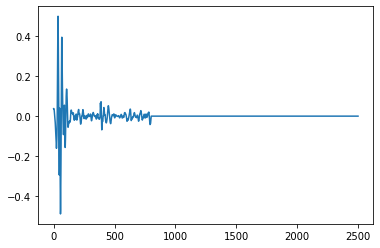

In [69]:
plt.plot(holdx[0,0,:])

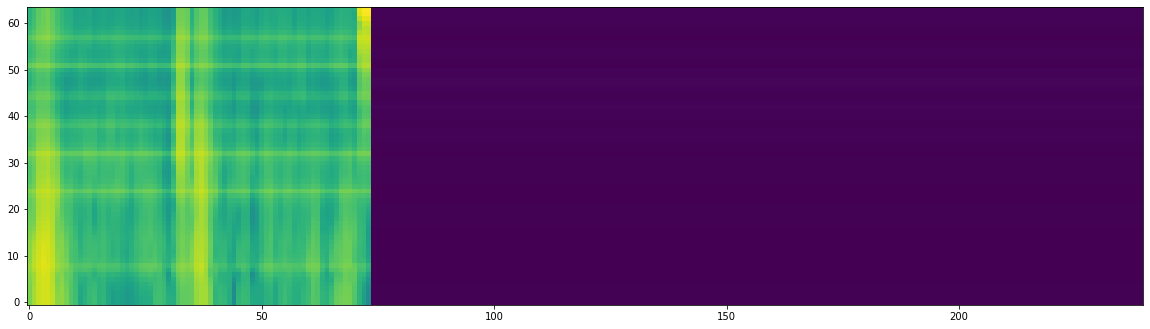

In [88]:
plt.figure(figsize=(20,20))
from matplotlib import cm
plt.imshow((to_numpy(hold[0,:,:])), interpolation='nearest', origin='lower')
# plt.plot(to_numpy(x[0,0,:,:]).transpose())

In [45]:
class_loss, domain_loss_source,domain_loss_target

(tensor(0.6931, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(2.0436, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(1.0436, device='cuda:0', grad_fn=<NllLossBackward>))

In [33]:
model.classifier.fc1.weight.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [87]:
x,[y,yd] = flow_source.next()
holdx = x
x,y,yd = torch.from_numpy(x),torch.from_numpy(y),torch.from_numpy(yd)
x = x.type(torch.FloatTensor).cuda()
y = y.long().cuda()
yd = yd.long().cuda()
x = mfcc_gen(x)
hold = x
x = x.transpose(2,1)
x = x.unsqueeze(1)
x,y,yd = Variable(x),Variable(y),Variable(yd)
y = y.long().cuda()

cls, dom = model(x)
class_loss = class_criterion(cls,y)
domain_loss_source = domain_criterion(dom,yd)

In [35]:
loss.backward()

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.